In [1]:
# User variables
SAVE_ELEMENTS = True # True if figures and models shall be saved

MAX_DURATION_JOURNEY = 180

In [2]:
# Imports
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import copy
from pm4py.objects.log.util import dataframe_utils
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
import json
import seaborn as sns
from collections import Counter
import subprocess

In [3]:
VERIFYTA_PATH = "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta"

# Preprocessing
The data is loaded and preprocessed.
Names of events are parsed and unused events are removed.

In [4]:
# removes unused events and parses event names
def process_touchpoint_names(df):
    print("Found types", set(df['Type']))
    running_df = df[df['Type'].isin(['state', 'feedback','subject', 'task', 'resultsShared'])].copy()
    running_df['concept:name'] = running_df['concept:name'].str.replace('\n', "") # rows might contain line-breaks; for different A, B, C tasks
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(",", "")
    running_df['concept:name'] = running_df['concept:name'].str.split('version').str[0]
    
    running_df['concept:name'] = running_df['concept:name'].str.split('Time used').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('taskDownloaded').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('testCompleted').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('itemCompleted').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.strip()

    m = running_df['concept:name'].str.contains("survey:")
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].str.split('survey: ').str[1]
    
    m = running_df['Type'] == 'state'
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].values
    running_df.loc[~m, 'concept:name'] = running_df['concept:name'][~m].values
    return running_df

# Filters the dataset to only contain traces with length in [lower_bound, upper_bound]
def get_filtered_df(path, lower_bound = 15, upper_bound = 60):
    df = pd.read_csv(path, sep = ";")
    log_csv = dataframe_utils.convert_timestamp_columns_in_df(df)
    log_csv = log_csv.sort_values('Timestamp')

    developers_finished_ids = set(log_csv[log_csv['Message'] == "finished"]['Developer ID'].sort_values().values)

    #rename columns to process mining notation
    log_csv.rename(columns={'Developer ID': 'case:DeveloperID', 'Message' : 'concept:name', 'Timestamp':'time:timestamp'}, inplace=True)
    log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'], unit='s')
    
    # process touchpoint names
    developers_df = process_touchpoint_names(log_csv)

    #filter used logs
    developers_df = developers_df.groupby(['case:DeveloperID']).filter(lambda x: len(x) >= lower_bound and len(x) <= upper_bound)

    unsuccesfull = developers_df[~developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    succesfull = developers_df[developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    plt.scatter(range(len(unsuccesfull)), unsuccesfull, c = "r", s = 7)
    plt.scatter(range(len(unsuccesfull),len(unsuccesfull)+(len(succesfull))), succesfull, c = "b", s = 7)
    plt.xlabel("Journeys")
    plt.ylabel("Length")
    plt.show()
    print("Includes #unsuccesfull:", len(unsuccesfull),"and #succesfull", len(succesfull))
    
    print("Histograms")
    sns.displot(data=pd.DataFrame({"Journey Length - Successfull": succesfull}),
            x="Journey Length - Successfull", color='blueviolet', height=3)
    plt.show()
    
    sns.displot(data=pd.DataFrame({"Journey Length - Unsuccessfull": unsuccesfull}),
            x="Journey Length - Unsuccessfull", color='blueviolet', height=3)
    plt.show()
    

    developers_df = developers_df.sort_values(by=['time:timestamp'])

    return developers_df

Found types {'vpcInstance', 'activate', 'state', 'latency', 'score', 'subject', 'feedback', 'resultsShared', 'task'}


/tmp/ipykernel_3667/3885284329.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_3667/3885284329.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


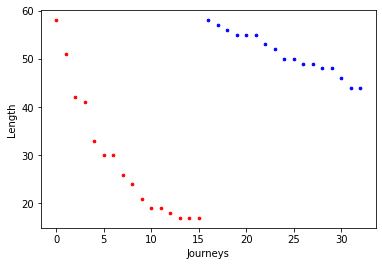

Includes #unsuccesfull: 16 and #succesfull 17
Histograms


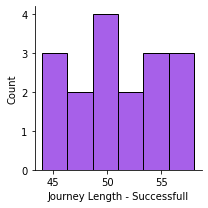

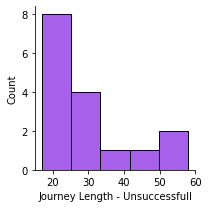

1970-01-27 15:22:16 1970-03-17 16:00:20
49 days 00:38:04 4235884.0


In [5]:
filtered_df_old = get_filtered_df("data.csv")
s1 = set(filtered_df_old["concept:name"])

started = filtered_df_old[filtered_df_old["concept:name"]=="registered"]
times = started["time:timestamp"]
print(min(times), max(times)) # two years
print(max(times)-min(times), (max(times)-min(times)).total_seconds())
WINDOW_SIZE = (max(times)-min(times)).total_seconds()

Found types {'vpcInstance', 'activate', 'state', 'latency', 'score', 'subject', 'feedback', 'resultsShared', 'task'}


/tmp/ipykernel_3667/3885284329.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_3667/3885284329.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


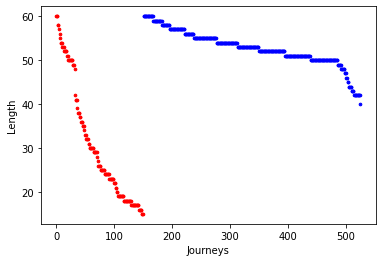

Includes #unsuccesfull: 151 and #succesfull 375
Histograms


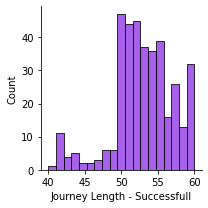

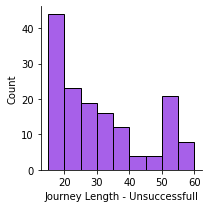

In [6]:
filtered_df = get_filtered_df("data_extended.csv")
s2 = set(filtered_df["concept:name"])

       Company ID Category  case:DeveloperID      time:timestamp     Type  \
25807           9      B2B               571 1970-03-25 23:51:59    state   
25808           9      B2B               571 1970-03-26 22:32:28    state   
25809           9      B2B               571 1970-03-26 22:32:28  subject   
25811           9      B2B               571 1970-03-26 22:32:29    state   
25810           9      B2B               571 1970-03-26 22:32:29    state   

                  concept:name  Unnamed: 6  
25807               registered         NaN  
25808                activated         NaN  
25809      Logged in: Web page         NaN  
25811  vpcCreateUserOnInstance         NaN  
25810        vpcAssignInstance         NaN  
number companies 18


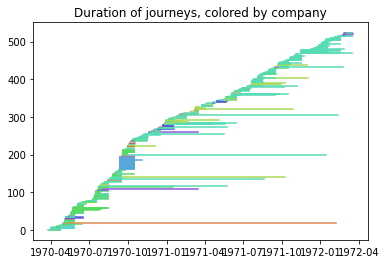

1970-03-25 23:51:59 1972-03-09 21:53:49


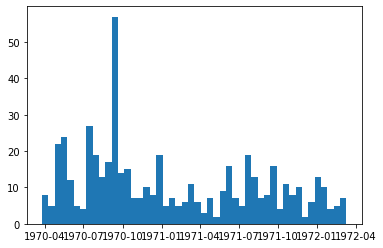

In [7]:
# investigate starting time-stamp
print(filtered_df.head())
times = {}
companies = {}
developers = set(filtered_df['case:DeveloperID'])

for d in developers:
    reduced = filtered_df[filtered_df['case:DeveloperID']==d]
    assert(len(set(reduced["Company ID"])) == 1)
    companies[d] = list(set(reduced["Company ID"]))[0]
    times[d] = (min(reduced["time:timestamp"]), max(reduced["time:timestamp"]))

number_companies = len(set(companies.values()))
company_iterator = {c : i for c,i in zip(set(companies.values()), range(number_companies))}
print("number companies", number_companies)

sorted_times = sorted(times.items(), key=lambda item: item[1])

count = 0
for t in sorted_times:
    company_it = company_iterator[companies[t[0]]]
    plt.plot([t[1][0],t[1][1]], [count, count], c=sns.color_palette("hls", number_companies)[company_it])
    count += 1
plt.title("Duration of journeys, colored by company")
plt.show()

started = filtered_df[filtered_df["concept:name"]=="registered"]
starting_times = started["time:timestamp"]
end_times = filtered_df.groupby(['case:DeveloperID']).max()["time:timestamp"]
print(min(starting_times), max(starting_times)) # two years
plt.hist(starting_times, 48)
plt.show()

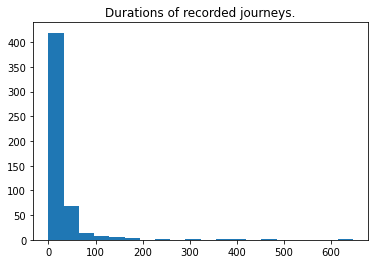

9


In [8]:
time_diffs = []
for t in times.values():
    time_diffs.append((t[1]-t[0]).days)

plt.hist(time_diffs, 20)
plt.title("Durations of recorded journeys.")
plt.show()

print(len([t for t in time_diffs if t > 180]))

In [9]:
print(sorted(s1))
print(sorted(s2))

print("In s1, not s2")
for a in s1:
    if a not in s2:
        print(a)

print("In s2, not s1")
for a in s2:
    if a not in s1:
        print(a, type(a))

['Give feedback', 'Logged in: Web page', 'Results automatically shared', 'Results shared', 'Task event:', 'Task event: loggedIn', 'activated', 'finished', 'readyToStart', 'registered', 'started', 'subjectAcceptanceReceived', 'vpcAssignInstance', 'vpcCreateUserOnInstance', 'waitingForActivityReport', 'waitingForManualScores', 'waitingForResultApproval', 'waitingForScores', 'waitingForSubjectAcceptance']
['Give feedback', 'Logged in: Web page', 'Results automatically shared', 'Results not shared', 'Results shared', 'Task event:', 'Task event: loggedIn', 'activated', 'finished', 'null', 'readyToStart', 'registered', 'started', 'subjectAcceptanceDeclined', 'subjectAcceptanceReceived', 'vpcAssignInstance', 'vpcCreateUserOnInstance', 'waitingForActivityReport', 'waitingForManualScores', 'waitingForResultApproval', 'waitingForScores', 'waitingForSubjectAcceptance']
In s1, not s2
In s2, not s1
subjectAcceptanceDeclined <class 'str'>
Results not shared <class 'str'>
null <class 'str'>


# Build log
The dataset is flattened to a log structure

In [10]:
success_states = ['finished']
# A log consists of traces, where each trace contains all elements from one developer 
def build_log(df, return_start_times = False):
    log = []
    start_times = [] # maps from developer to timestamp
    running_df = df.copy()
    running_df = running_df.sort_values(by=['time:timestamp'])
    developers_id = set(running_df['case:DeveloperID'].values)
    for dev_id in developers_id:
        current_trace = running_df[running_df['case:DeveloperID'] == dev_id]['concept:name'].values

        trace_start = min(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'])
        trace_end = max(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'])

        if ((trace_end-trace_start).days > MAX_DURATION_JOURNEY):
            print("omitted developer", dev_id, "due to length")
            continue
        
        # add unique start node "start"
        current_trace = np.insert(current_trace,0,"start")
        # attach final node finPos / finNeg
        if(any(s in current_trace for s in success_states)):
            current_trace = np.append(current_trace,"finPos")
        else:
            current_trace = np.append(current_trace,"finNeg")
        log.append(current_trace)
        start_times.append(min(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp']))
        
    # alter "logged in: Web page" to determine phase of journey:
    # Phase (1) sign up, (2) solve all programming tasks, and  (3) review and share the skill report with the customer.
    for t in log:
        indices = [i for i, x in enumerate(t) if x == "Logged in: Web page"]
        for i in indices:
            t[i] = "Logged in: Web page - Sign up"
            result = np.where(t == "Task event:")
            if "Task event:" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Task"
            result = np.where(t == "waitingForResultApproval")
            if "waitingForResultApproval" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Approval"
                
    # add task number
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_task:
            count_indices = [j for j in indices_feedback if j < i] # uses feedback to increase task counter after giving feedback
            t[i] += " "+str(len(count_indices))
    # add feedback number        
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_feedback:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    """
    # add number to log in:
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_loggin = [i for i, x in enumerate(t) if x == "Task event: loggedIn"]
        for i in indices_loggin:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    """

    if return_start_times:
        return log, start_times
    return log

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

In [11]:
def filter_doubles(log):
    filtered_log = []
    for index in range(len(log)):
        # remove sequential same elements
        trace = log[index]
        current_trace = [trace[0]]

        for pos in range(1,len(trace)):
            if trace[pos]==trace[pos-1]:
                continue
            current_trace.append(trace[pos])

        filtered_log.append(current_trace)
    return filtered_log

In [12]:
log, start_times = build_log(filtered_df, return_start_times=True)
log = filter_doubles(log) 

omitted developer 40 due to length
omitted developer 93 due to length
omitted developer 233 due to length
omitted developer 270 due to length
omitted developer 658 due to length
omitted developer 720 due to length
omitted developer 1041 due to length
omitted developer 1103 due to length
omitted developer 1249 due to length


In [13]:
log_old = build_log(filtered_df_old)
log_old = filter_doubles(log_old)

In [14]:
for trace_old in log_old:
    found = False
    for trace in log:
        if len(trace) != len(trace_old):
            continue
        if trace_old == trace:
            found = True
            break
    if not found:
        print("not found", trace_old)
        break

not found ['start', 'registered', 'Logged in: Web page - Sign up', 'activated', 'vpcAssignInstance', 'vpcCreateUserOnInstance', 'readyToStart', 'Task event: loggedIn', 'started', 'Task event: 0', 'Give feedback 0', 'Task event: 1', 'Give feedback 1', 'Task event: 2', 'Give feedback 2', 'Task event: 3', 'Give feedback 3', 'Task event: 4', 'waitingForManualScores', 'Task event: 4', 'Logged in: Web page - Task', 'waitingForScores', 'waitingForResultApproval', 'waitingForActivityReport', 'finished', 'finPos']


Variants before removing trivial elements
437


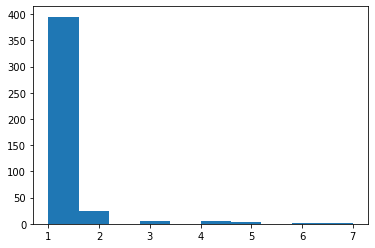

In [15]:
# variants in log
print("Variants before removing trivial elements")
variants_counter = Counter(str(e) for e in log)
plt.hist(variants_counter.values(), 10)
print(len(Counter(str(e) for e in log).keys()))

# Create DFG

In [134]:
# Builds the directly follows graph according to the log
# Removes all edges which are traversed less than "threshold" times
def build_dfg(log, threshold):
    states = list(set([item for sublist in log for item in sublist])) # flatten list

    edges = []
    edge_counter = {}
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
    
    g = nx.DiGraph()
    g.add_nodes_from(states)
    max_val = max(edge_counter.values())
    for e in edges:
        g.add_edge(e[0], e[1], edge_weight = edge_counter[e]/max_val) # adds "thickness" element

    # remove all simple loops & rarely traversed edges
    to_remove = []
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        if edge_counter[e] <= threshold:
            to_remove.append(e)

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
            
    
    # remove isolated nodes
    g.remove_nodes_from(list(nx.isolates(g)))
    
    return g

def draw_dfg(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"
    for e in g.edges:
        e = A.get_edge(e[0], e[1])
        if 'controllable' in g.edges[e]:
            if not g.edges[e]['controllable']:
                e.attr["style"] = "dotted"
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
    print("plotted", name)

In [17]:
g = build_dfg(log,4)
draw_dfg(g, "graph.ps")
g_old = build_dfg(log_old,3)
draw_dfg(g_old, "graph_old.ps")

plotted graph.ps
plotted graph_old.ps


# Burnd-Down Chart of Developers

In [18]:
# Draw the burn down chart of developers leaving the journey per touchpoint, Figure 6
def draw_burn_down(g,s, t, log):
    g_copy = copy.deepcopy(g)
    edge_counter = {}
    node_counter = {}
    
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edge_counter:
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
            
    for trace in log:
        for pos in set(trace):
            if pos in node_counter:
                node_counter[pos] = node_counter[pos]+1
            else:
                node_counter[pos] = 1
            continue

    for e in edge_counter:
        if e[1] == "finNeg":
            print(e, edge_counter[e])
    
    x = [100,81, 72, 64, 52]
    y = ["start", "T10", "T12", "T14", "T25"]
    x2 = [0,18,9,9,12]
    y2 = ["start", "T10", "T12", "T14", "T25"]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(y,x, 'o-')
    ax.bar(y2, x2, color="r")
    plt.ylabel("Developers (in %)", fontsize=18)
    plt.xlabel("Events", fontsize=18)
    plt.show()

('waitingForActivityReport', 'finNeg') 27
('Logged in: Web page - Approval', 'finNeg') 10
('Task event: loggedIn', 'finNeg') 12
('Task event: 1', 'finNeg') 38
('Task event: 2', 'finNeg') 25
('Task event: 0', 'finNeg') 3
('Task event: 4', 'finNeg') 6
('Task event: 3', 'finNeg') 13
('Logged in: Web page - Task', 'finNeg') 11
('Logged in: Web page - Sign up', 'finNeg') 2
('vpcAssignInstance', 'finNeg') 1
('readyToStart', 'finNeg') 1
('waitingForManualScores', 'finNeg') 1


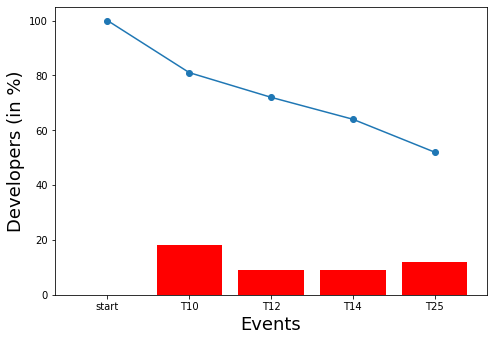

In [19]:
draw_burn_down(g, "start", "finNeg", log)

# DFG to Customer Journey Game

In [20]:
# load actors from given file
# The file maps events to actors in xml format
# Every unspecified event is controllable
with open('activities.xml') as f:
    data = f.read()
actors = json.loads(data)

In [21]:
# stores actors in graph
def extend_graph_with_actors(g, actors):  
    for node in g.nodes:
        if node not in actors:
            g.nodes[node]['controllable'] = True
        else:
            g.nodes[node]['controllable'] = actors[node] == "company"

In [22]:
extend_graph_with_actors(g,actors)

In [23]:
# Helper functions to compute weights for edges

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

def weight(trace):
    return 1 if any("finished" in pos for pos in trace) else -1

def majority(s,t,log):
    maj = 0
    for trace in log:
        if isInTrace(s,t,trace):
            maj += weight(trace)
    return 1 if maj == 0 else int(maj/abs(maj))

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping = []):
    distr = {1.0: 0 , -1.0 : 0}
    if edge_mapping == []: # old function
        for trace in log:
            if isInTrace(s,t,trace):
                w = weight(trace)
                distr[w] += 1
    else:# use abstraction
        assert((s,t) in edge_mapping)
        for trace_index in edge_mapping[(s,t)]:
            w = weight(log[trace_index])
            distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, log, edge_mapping = []):
    weights = [1 if "finished" in i else -1 for i in log]
    edge_cost = {}
    for s in g.nodes:
        for t in g[s]:
            p1, p2 = distribution(s,t,log, edge_mapping)
            if p1 +  p2 == 0:
                assert(False)
            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)
            #w = majority(s,t,log)
            w = 1 if p1 >= p2 else -1
            scaling = 10
            edge_cost[(s,t)] = (((1-entropy(wp1,wp2)) * w) -0.1 )*20
    print("Edge cost was computed")
    return edge_cost

In [24]:
edge_cost = compute_edge_cost(g, log)

Edge cost was computed


In [25]:
# annotates graph with cost-labels
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

# Colors graph labels green/red depending of the weight is positive or negative
def color_graph(g):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > 0:
            g[e[0]][e[1]]['color'] ="darkgreen"
        if g[e[0]][e[1]]['label'] < 0:
            g[e[0]][e[1]]['color'] ="red"
    
    return g

# Plots clustered DFG, Figure 5
def draw_dfg_clustered(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = 70
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"

    for n in A.nodes():
        n.attr['fontsize'] = 80
    onboarding = ["T"+str(i) for i in range(0,6)]
    A.add_subgraph(onboarding, name='cluster_onboarding', label= "Sign-up", color = "orange", fontsize = 60, fontcolor = "orange")
    task = ["T"+str(i) for i in range(6,21)]
    A.add_subgraph(task, name='cluster_task', label= "Solve tasks", color = "blue", fontsize = 60, fontcolor = "blue")
    evaluation = ["T"+str(i) for i in range(21,27)]
    A.add_subgraph(evaluation, name='cluster_evaluation', label= "Review and share", color = "purple", fontsize = 60, fontcolor = "purple")

    reversed_naming = {naming[i] : i for i in naming}
    for n in A.nodes():
        if n not in reversed_naming:
            continue
        n.attr['label'] = reversed_naming[n]
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
        
# Introduced naming for readable function
naming = {
    "registered" : "T0",
    "activated": "T1",
    "Logged in: Web page - Sign up" : "T2",
    "vpcCreateUserOnInstance" : "T3",
    "vpcAssignInstance" : "T4",
    "readyToStart" : "T5",
    "Task event: loggedIn" : "T6",
    "started" : "T7",
    "Task event: 0": "T8",
    "Give feedback 0" : "T9",
    "Task event: 1": "T10",
    "Give feedback 1" : "T11",
    "Task event: 2": "T12",
    "Give feedback 2" : "T13",
    "Task event: 3": "T14",
    "Give feedback 3" : "T15",
    "Task event: 4": "T16",
    "Give feedback 4" : "T17",
    "Task event: 5": "T18",
    "waitingForManualScores" : "T19",
    "Logged in: Web page - Task" : "T20",
    "waitingForScores" : "T21",
    "waitingForResultApproval" : "T22",
    "waitingForSubjectAcceptance" : "T23",
    "subjectAcceptanceReceived" : "T24",
    "Results automatically shared" : "T24",
    "waitingForActivityReport" : "T25",
    "Logged in: Web page - Approval" : "T26"
}

In [26]:
g = annotate_graph(g, edge_cost)
g_outgoing = color_graph(g)
g_outgoing = nx.relabel_nodes(g_outgoing, naming)
draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

# Mapping to UPPAAL Model

In [27]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True


# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]): # transition systems store controllability in edges
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']
                if('controllable' in G.nodes[t_original]): # dfg stores in nodes
                    G_gen.nodes[t]['controllable'] = G.nodes[t_original]['controllable']

    print("Graph was unrolled")
    return G_gen

In [28]:
#g_unroll = unroll(g, "start", ["finPos", "finNeg"], 1)
#A = to_agraph(g_unroll)
#A.layout('dot')
#if SAVE_ELEMENTS:
#    A.draw('unrolled.ps')

In [29]:
# Method to produce unrolled graph
def to_uppaal(g):
    f = open("unrolled_graph.xml", "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot', args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int gas = 0;')
    f.write('\n'+'int finalGasMax = 0;')
    f.write('\n'+'int finalGasMin = 10000;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    for e in g.edges:
        final = True if "finPos" in e[1] or "finNeg" in e[1] else False
        print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g.nodes[e[1]]['controllable'], final = final)
    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("All written to", f.name)

def print_location(f, location_id, x, y, name):
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y))+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if "finPos" not in name and "finNeg" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, weight, controllable, final = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if final:
        f.write('finalGasMax = gas +'+str(int(round(weight))))
        f.write(',\n'+'finalGasMin = gas +'+str(int(round(weight))))
        f.write(',\n'+ 'gas = gas + '+str(int(round(weight))))
    else:
        f.write('gas = gas + '+str(int(round(weight))))
    
    f.write(',\n'+ 'steps += 1')
    f.write(',\n'+ 'x = 0')
    
    f.write('</label>')
    
    f.write('</transition>')


In [30]:
#if SAVE_ELEMENTS:
#    to_uppaal(g_unroll)

##  UPPAAL
This generated model can then by model checked with UPPAAL.

# Generate Simulation Plot
Generates comparison plot between GoPos and GoPosFast, Figure 7

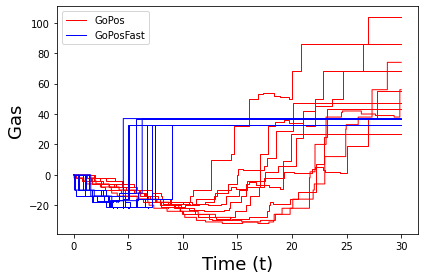

In [31]:
def read_csv(path):
    simulations = []
    lines = []
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    lines = [line for line in lines if "##" not in line]
    lines.pop(0)
    x = []
    y = []
    current_x = []
    current_y = []
    current_simulation = []
    for line in lines:
        if "#" in line:
            current_x.append(30)
            current_y.append(current_y[-1])
            x.append(current_x)
            y.append(current_y)
            current_x = []
            current_y = []
        else:
            current_x.append(float(line.split(",")[0]))
            current_y.append(float(line.split(",")[1]))
    return x,y

x,y = read_csv("gopos.csv")
x_fast, y_fast = read_csv("goposfast.csv")
plt.rcParams["figure.autolayout"] = True
for i in range(len(x)):
    if i == len(x)-1:
        plt.plot(x[i],y[i], c = "r", linewidth = 1, label = "GoPos")
    else:
        plt.plot(x[i],y[i], c = "r", linewidth = 1)
for i in range(len(x_fast)):
    if i == len(x_fast)-1:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1, label = "GoPosFast")
    else:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1)
plt.legend()
plt.savefig("simulation.png")
plt.xlabel("Time (t)",  fontsize=18)
plt.ylabel("Gas",  fontsize=18)
plt.show()

# Analysing Time Series

In [32]:
for trace in log:
    if "vpcCreateUserOnInstance" not in trace:
        print(trace)
        assert(False)
    if "vpcAssignInstance" not in trace:
        print(trace)
        assert(False)

In [33]:
# sort log with start_times

def sliding_window_logs(log, start_times, window_size_seconds, min_size = 10):
    merged = [(log, start_time) for log, start_time in zip (log, start_times)]
    start_times_sorted = sorted(merged, key=lambda item: item[1])
    sorted_log = [s[0] for s in start_times_sorted]
    sorted_times = [s[1] for s in start_times_sorted]

    assert(sorted(start_times) == sorted_times)
    sliced_logs = []

    for current_start in sorted_times:
        current_log = []
        for trace, start_time in zip(log, sorted_times):
            if start_time < current_start:
                continue
            if (start_time - current_start).total_seconds() > window_size_seconds:
                break
            current_log.append(trace)
        if len(current_log)>min_size:
            sliced_logs.append(current_log)

    return sliced_logs
sliced_logs = sliding_window_logs(log, start_times, WINDOW_SIZE)

507


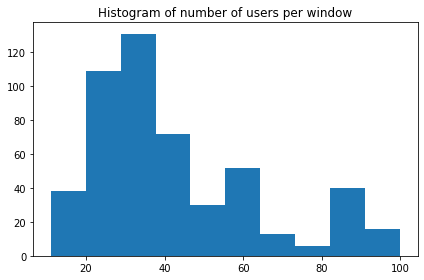

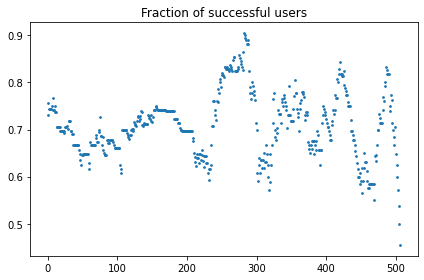

In [34]:
print(len(sliced_logs))
plt.hist([len(l) for l in sliced_logs])
plt.title("Histogram of number of users per window")
plt.show()

fractions = []
for l in sliced_logs:
    pos = [t for t in l if "finPos" in t]
    neg = [t for t in l if "finNeg" in t]
    fractions.append(len(pos)/len(l))
    assert(len(pos)+len(neg) == len(l))
plt.scatter(range(len(fractions)), fractions, s = 3)
plt.title("Fraction of successful users")
plt.show()

In [94]:
def time_analysis(sliced_logs, edge_threshold_start = 3, compute_distance = True):
    result_dict = {
        "loops" : [],
        "mc_results" : [],
        "distances" : [],
        "colors" : [],
        "distanced_previous" : [0],
        "fractions" : [],
        "edge_thresholds" : [],
        "sums" : [],
        "accuracies" : [],
        "images" : [],
        "negative_edges" : []
    }

    omitted_counter = 0
    successfully_computed = 0

    for l in sliced_logs:
        result_dict["fractions"].append(len([t for t in l if "finPos" in t])/len(l))
        edge_threshold = edge_threshold_start

        if compute_distance:
            if len(result_dict["distances"]) > 0:
                result_dict["distances_previous"].append(nx.graph_edit_distance(build_dfg(l, edge_threshold), help_g, timeout = 10))

        help_g = build_dfg(l, edge_threshold)

        while not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
            print("not connected")
            draw_dfg(help_g, "graph_error.ps")
            edge_threshold -= 1
            if edge_threshold == -1:
                assert(False)
            help_g = build_dfg(l, edge_threshold)
            draw_dfg(help_g, "graph_error.ps")

        loop_number = len(list(nx.simple_cycles(help_g)))
        while(loop_number > 6):
            edge_threshold += 1
            help_g = build_dfg(l, edge_threshold)
            loop_number = len(list(nx.simple_cycles(help_g)))

        if compute_distance:
            print("compute distance")
            result_dict["distances"].append(nx.graph_edit_distance(g_old, help_g, timeout = 10))
        #assert(nx.is_weakly_connected(help_g))
        result_dict["loops"].append(loop_number)
        result_dict["edge_thresholds"].append(edge_threshold)
        #while len(list(nx.simple_cycles(help_g)))>8:
        #    edge_threshold += 1
        #    help_g = build_dfg(l, edge_threshold)
        #    print("in loop")
        if len(list(nx.simple_cycles(help_g))) > 6 or not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
            omitted_counter += 1
            result_dict["colors"].append("r")
            continue
        extend_graph_with_actors(help_g,actors)
        help_edge_cost = compute_edge_cost(help_g, l)

        negative_edges = [e for e in help_edge_cost if help_edge_cost[e] < 0]
        result_dict["negative_edges"].append(negative_edges)

        sums = [] #sums for log
        for trace in l:
            running_sum = 0
            pairs = [(trace[i], trace[i+1]) for i in range(len(trace)-1)]
            running_sum = sum(help_edge_cost[p] for p in pairs if p in help_edge_cost)
            sums.append(running_sum)
        result_dict["sums"].append(running_sum)

        # think more if accuracies good to include - seems to be difficult to defend...
        #
        #true_values = ["finPos" in t for t in l]
        #print("true vals", true_values)
        #print(len([t for t in l if "finPos" in t])/len(l))
        #correct_value = 0
        #for i in range(len(sums)):
        #    print(sums[i], true_values[i],sums[i]*true_values[i] )
        #    if sums[i]>0 and true_values[i] :
        #        correct_value+=1
        #print("accuracy", correct_value, len(l))
        #result_dict["accuracies"].append(correct_value/len(l))

        help_g = annotate_graph(help_g, help_edge_cost)
        help_g_outgoing = color_graph(help_g)
        
        if "start" not in help_g.nodes:
            print(len(l))
            print(l)
            draw_dfg(help_g, "graph_error.ps")
        
        file_name = "./gif/graph"+str(len(result_dict["loops"]))+".png"
        to_gif_g = copy.deepcopy(help_g)
        for e in to_gif_g.edges:
            if help_edge_cost[e] < 0:
                to_gif_g.edges[e]['color'] = "red"
        draw_dfg(to_gif_g, file_name)
        result_dict["images"].append(file_name)
        continue

        help_g_unroll = unroll(help_g, "start", ["finPos", "finNeg"], 1)
        draw_dfg(help_g, "graph_loops.ps")
        #draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
        to_uppaal(help_g_unroll)

        out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
        out.wait()
        results, err = out.communicate()
        results = results.decode("utf-8") 
        err = err.decode("utf-8") 
        if err != "":
            results = [-1,-1,-1,-1,-1,-1]
        else:
            results = results.split("\n")
            results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
            results = [r.replace("≈", "") for r in results]
            results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
            successfully_computed += 1
        assert(len(results) == 6)

        result_dict["mc_results"].append(results)
        
        result_dict["colors"].append("b" if list(set(results)) == [-1] else "g")
        print("Progress", len(result_dict["loops"]), "/", len(sliced_logs))

    print("Successfully computed", successfully_computed)
    return result_dict

sliced_logs = sliding_window_logs(log, start_times, WINDOW_SIZE)
sliced_logs = sliced_logs[::10]
result_dict = time_analysis(sliced_logs, compute_distance=False)

Edge cost was computed
plotted ./gif/graph1.png
Edge cost was computed
plotted ./gif/graph2.png
Edge cost was computed
plotted ./gif/graph3.png
Edge cost was computed
plotted ./gif/graph4.png
Edge cost was computed
plotted ./gif/graph5.png
Edge cost was computed
plotted ./gif/graph6.png
Edge cost was computed
plotted ./gif/graph7.png
Edge cost was computed
plotted ./gif/graph8.png
Edge cost was computed
plotted ./gif/graph9.png
Edge cost was computed
plotted ./gif/graph10.png
Edge cost was computed
plotted ./gif/graph11.png
Edge cost was computed
plotted ./gif/graph12.png
Edge cost was computed
plotted ./gif/graph13.png
Edge cost was computed
plotted ./gif/graph15.png
Edge cost was computed
plotted ./gif/graph16.png
Edge cost was computed
plotted ./gif/graph17.png
Edge cost was computed
plotted ./gif/graph18.png
Edge cost was computed
plotted ./gif/graph19.png
Edge cost was computed
plotted ./gif/graph20.png
Edge cost was computed
plotted ./gif/graph21.png
Edge cost was computed
plotte

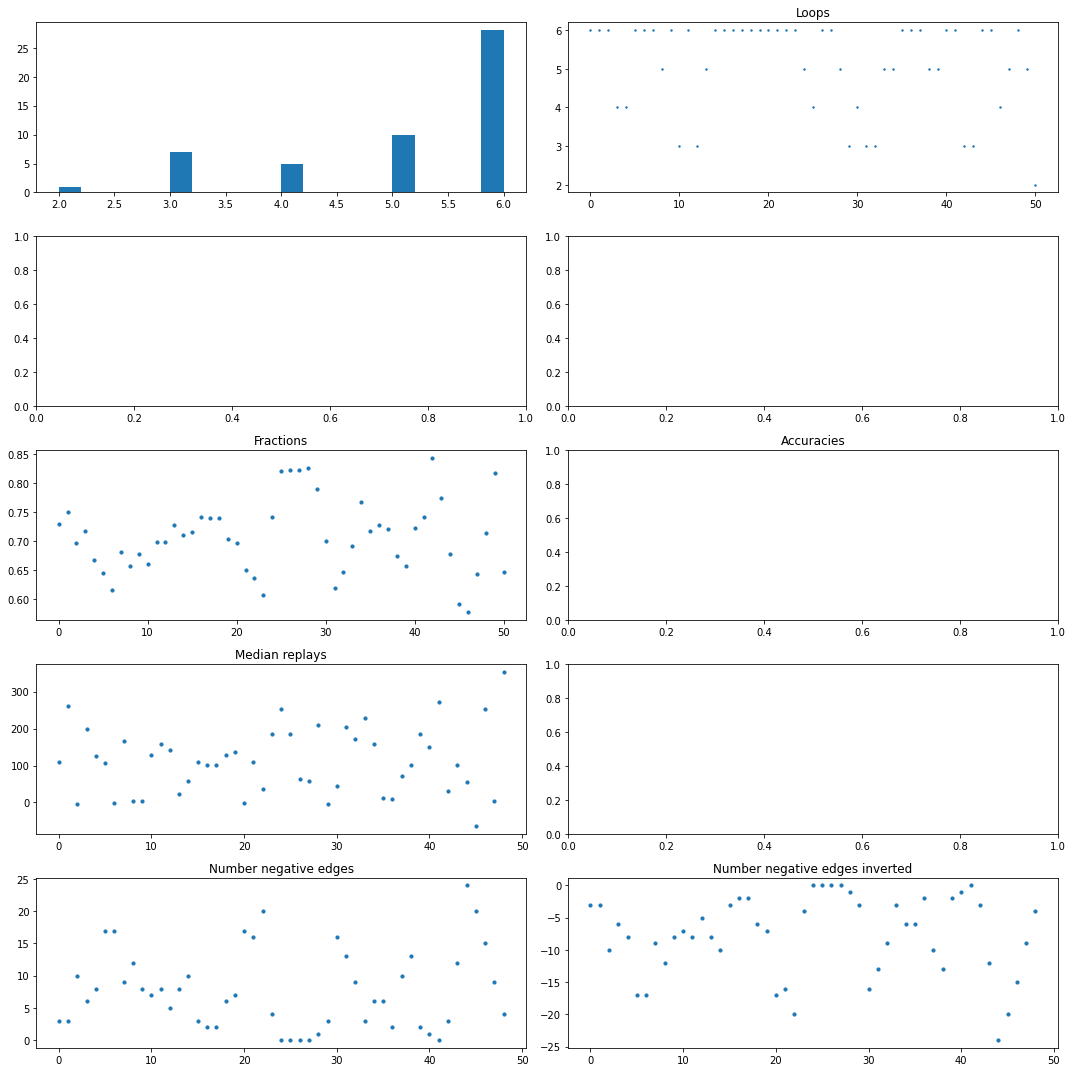

In [104]:
def plot_results(result_dict):
    colors = result_dict["colors"]
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0,0].hist(result_dict["loops"], 20)

    axs[0,1].scatter(range(len(result_dict["loops"])), result_dict["loops"], s = 2)
    axs[0,1].set_title("Loops")

    #axs[1,0].scatter(range(len(result_dict["distances"])), result_dict["distances"], s = 2, c = colors)
    #axs[1,0].title("Distances")

    #axs[1,1].scatter(range(len(result_dict["distances_previous"])), result_dict["distances_previous"], s = 2, c = colors)
    #axs[1,1].title("Pairwise - Distances")
    axs[2,0].scatter(range(len(result_dict["fractions"])), result_dict["fractions"], s = 10)
    axs[2,0].set_title("Fractions")

    #for i in range(len(result_dict["accuracies"])):
    #    print(result_dict["accuracies"][i] == result_dict["fractions"][i])
    #axs[2,1].scatter(range(len(result_dict["accuracies"])), result_dict["accuracies"], c = colors)
    axs[2,1].set_title("Accuracies")

    axs[3,0].scatter(range(len(result_dict["sums"])), [np.median(s) for s in result_dict["sums"]], s = 10)
    axs[3,0].set_title("Median replays")

    axs[4,0].scatter(range(len(result_dict["negative_edges"])), [len(e) for e in result_dict["negative_edges"]], s = 10)
    axs[4,0].set_title("Number negative edges")

    axs[4,1].scatter(range(len(result_dict["negative_edges"])), [-len(e) for e in result_dict["negative_edges"]], s = 10)
    axs[4,1].set_title("Number negative edges inverted")

plot_results(result_dict)

In [119]:
negative_edges = result_dict["negative_edges"]
edge_set = {}
for inner_set in negative_edges:
    for e in inner_set:
        if e not in edge_set:
            edge_set[e] = 1
        else:
            edge_set[e] += 1
dict(sorted(edge_set.items(), key=lambda item: item[1], reverse = True))

{('Task event: 0', 'Task event: loggedIn'): 28,
 ('started', 'Task event: 0'): 24,
 ('Task event: loggedIn', 'started'): 24,
 ('registered', 'Logged in: Web page - Sign up'): 23,
 ('Logged in: Web page - Sign up', 'activated'): 23,
 ('vpcCreateUserOnInstance', 'readyToStart'): 22,
 ('vpcAssignInstance', 'vpcCreateUserOnInstance'): 21,
 ('readyToStart', 'Task event: loggedIn'): 19,
 ('registered', 'activated'): 17,
 ('activated', 'vpcAssignInstance'): 17,
 ('start', 'registered'): 17,
 ('activated', 'Logged in: Web page - Sign up'): 16,
 ('Logged in: Web page - Sign up', 'vpcAssignInstance'): 16,
 ('started', 'Task event: loggedIn'): 14,
 ('Task event: loggedIn', 'Task event: 0'): 12,
 ('Give feedback 0', 'Task event: 1'): 11,
 ('readyToStart', 'started'): 10,
 ('Results automatically shared', 'subjectAcceptanceReceived'): 8,
 ('waitingForSubjectAcceptance', 'Results automatically shared'): 7,
 ('vpcAssignInstance', 'readyToStart'): 7,
 ('vpcCreateUserOnInstance', 'vpcAssignInstance'): 

In [84]:
# generate git from images
import imageio
images = []

for filename in result_dict["images"]:
    images.append(imageio.imread(filename))
imageio.mimsave('./gif/merged.gif', images, fps=3)

/tmp/ipykernel_3667/787545883.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
1 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
2 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
3 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
4 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
5 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
6 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
7 / 104
compute distance
Edge cost was computed
Graph was unrolled
plotted graph_loops.ps
All written to unrolled_graph.xml
8 / 104
compute 

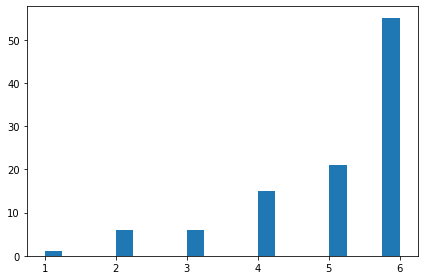

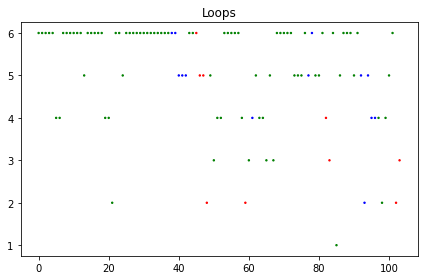

6
successfully computed 95


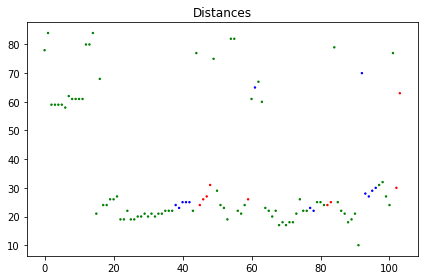

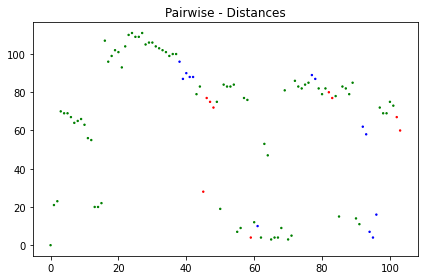

In [177]:
loops = []
omitted_counter = 0
successfully_computed = 0
colors = []
time_results = []
distances = []
distances_previous = [0]
sliced_logs = sliding_window_logs(log, start_times, WINDOW_SIZE)
sliced_logs = sliced_logs[0::5]
for l in sliced_logs:
    edge_threshold = 3

    if len(distances) > 0:
        distances_previous.append(nx.graph_edit_distance(build_dfg(l, edge_threshold), help_g, timeout = 10))

    help_g = build_dfg(l, edge_threshold)

    while not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
        print("not connected")
        draw_dfg(help_g, "graph_error.ps")
        edge_threshold -= 1
        if edge_threshold == -1:
            assert(False)
        help_g = build_dfg(l, edge_threshold)
        draw_dfg(help_g, "graph_error.ps")

    loop_number = len(list(nx.simple_cycles(help_g)))
    while(loop_number > 6):
        edge_threshold += 1
        help_g = build_dfg(l, edge_threshold)
        loop_number = len(list(nx.simple_cycles(help_g)))

    print("compute distance")
    distances.append(nx.graph_edit_distance(g_old, help_g, timeout = 10))
    #assert(nx.is_weakly_connected(help_g))
    loops.append(loop_number)

    #while len(list(nx.simple_cycles(help_g)))>8:
    #    edge_threshold += 1
    #    help_g = build_dfg(l, edge_threshold)
    #    print("in loop")
    if len(list(nx.simple_cycles(help_g))) > 6 or not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
        omitted_counter += 1
        colors.append("r")
        continue
    extend_graph_with_actors(help_g,actors)
    help_edge_cost = compute_edge_cost(help_g, l)

    help_g = annotate_graph(help_g, help_edge_cost)
    help_g_outgoing = color_graph(help_g)
    
    if "start" not in help_g.nodes:
        print(len(l))
        print(l)
        draw_dfg(help_g, "graph_error.ps")
    
    

    help_g_unroll = unroll(help_g, "start", ["finPos", "finNeg"], 1)
    draw_dfg(help_g, "graph_loops.ps")
    #draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
    to_uppaal(help_g_unroll)

    out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
    out.wait()
    results, err = out.communicate()
    results = results.decode("utf-8") 
    err = err.decode("utf-8") 
    #if "Formula is NOT satisfied" in results:
    if err != "":
        results = [-1,-1,-1,-1,-1,-1]
    else:
        results = results.split("\n")
        results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
        results = [r.replace("≈", "") for r in results]
        results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
    assert(len(results) == 6)

    time_results.append(results)
    successfully_computed += 1
    colors.append("b" if list(set(results)) == [-1] else "g")
    print(len(loops), "/", len(sliced_logs))

plt.hist(loops, 20)
plt.show()
plt.scatter(range(len(loops)), loops, s = 2, c = colors)
plt.title("Loops")
plt.show()
print(max(loops))
print("successfully computed", successfully_computed)
plt.scatter(range(len(distances)), distances, s = 2, c = colors)
plt.title("Distances")
plt.show()
plt.scatter(range(len(distances_previous)), distances_previous, s = 2, c = colors)
plt.title("Pairwise - Distances")
plt.show()

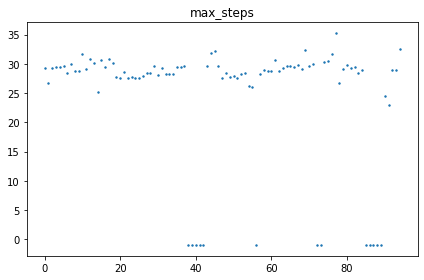

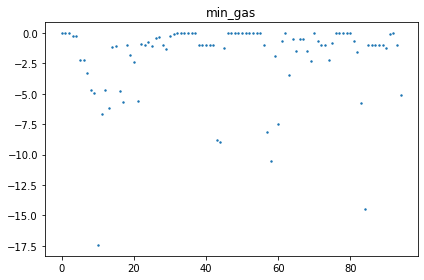

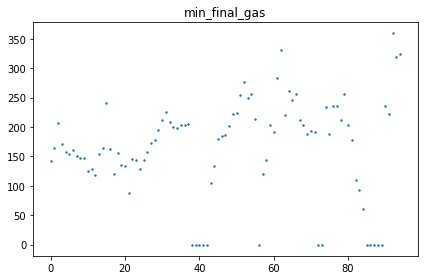

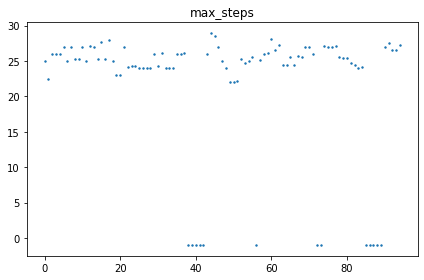

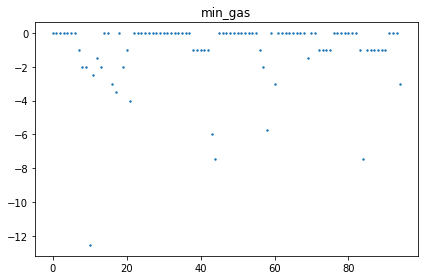

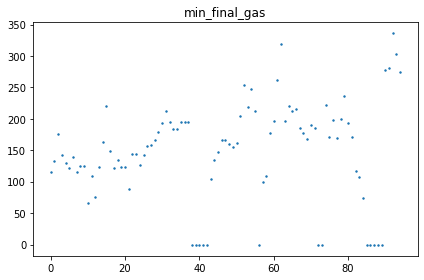

In [180]:
lables = ["max_steps", "min_gas", "min_final_gas"]
for i in range(6):
    plt.scatter(range(len(time_results)), [r[i] for r in time_results], s = 2)
    plt.title(lables[i%3])
    plt.show()

In [120]:
loop_number = len(list(nx.simple_cycles(g_old)))
print(loop_number)
nx.graph_edit_distance(g_old, help_g, timeout = 10)

6


36.0

In [140]:
#transition system needs different write-to-xml methods

# construction of uppaal model (write model into upaal file)
def to_uppaal(g, name, layout = "sfdp", debug = False):
    f = open(name, "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog=layout, args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int e = 0;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('\n'+'bool reached_positive = false;')
    f.write('\n'+'bool reached_negative = false;')
    f.write('\n'+'int final_gas = -1;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
        f.write('\n')
                    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    
    for e in g.edges:
        assert("label" in g[e[0]][e[1]] and "controllable" in g[e[0]][e[1]])
        print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)

    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    if debug:
        print("all written to", f.name)

def print_location(f, location_id, x, y, name):
    name = str(name)
    name = name.replace('"', '-')
    name = name.replace('{', '')
    name = name.replace('}', '')
    name = name.replace("'", '-')
    name = name.replace("_", '')
    name = name.replace("(", '')
    name = name.replace(")", '')
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y)+20)+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y)-30)+'">')
    if "positive" not in name and "negative" not in name and "outOfGas" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, w, controllable, e, g, guard = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
        
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write(' steps += 1')
    f.write(',\n'+ 'x = 0')
    if "finPos" in str(e[1]):
        f.write(',\n'+ 'reached_positive = true')
        f.write(',\n'+ 'final_gas = e +'+str(int(round(w))))
    elif "finNeg" in str(e[1]):
        f.write(',\n'+ 'reached_negative = true')
        f.write(',\n'+ 'final_gas = e + '+str(int(round(w))))
        
    f.write(',\n'+'e = e + '+str(int(round(w))))
    f.write('</label>')
    
    f.write('</transition>')

In [141]:
# Concats the trace to a multiset-history
def ms(trace):
    multiset = {}
    for pos in trace:
        if pos not in multiset:
            multiset[pos] = 1
        else:
            multiset[pos] += 1
    return json.dumps(multiset, sort_keys=True).encode().decode("utf-8") # use json encodings for multisets

# Computes the sequence-history of the given trace
def sequence(trace): 
    hist = str(trace[0])
    for pos in trace[1:]:
        hist += " - " + str(pos) # construct history
    return hist

# Function to compute a transition system, given a pre-processed log
def transition_system(log, history, abstraction):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = abstraction(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                edge_counter[e] = edge_counter[e]+1
                edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = [] # to remove selve-loops
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        # set properties
        g[e[0]][e[1]]['action'] = action[e]

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    
    return g, edge_mapping

def extend_graph_with_actors(g,actors):
    for e in g.edges:
        controllable_set = False
        for key in actors:
            if key in g.edges[e]['action']:
                controllable_set = True
                g.edges[e]['controllable'] = actors[key] == 'company'
        if not controllable_set:
            g.edges[e]['controllable'] = True

In [142]:
g_old_history, h = transition_system(log_old, 3, sequence)

In [144]:
loops = []
omitted_counter = 0
successfully_computed = 0
colors = []
time_results = []
distances = []
distances_previous = [0]
sliced_logs = sliding_window_logs(log, start_times, WINDOW_SIZE)
sliced_logs = sliced_logs[200::50]
for l in sliced_logs:
    edge_threshold = 3

    if len(distances) > 0:
        h1, h2 = transition_system(l, 3, sequence)
        distances_previous.append(nx.graph_edit_distance(h1, help_g, timeout = 1))

    help_g, edge_mapping = transition_system(l, 2, sequence)

    loop_number = len(list(nx.simple_cycles(help_g)))

    print("compute distance")
    distances.append(nx.graph_edit_distance(g_old_history, help_g, timeout = 1))
    #assert(nx.is_weakly_connected(help_g))
    loops.append(loop_number)
    print("loop number", loop_number)
    #while len(list(nx.simple_cycles(help_g)))>8:
    #    edge_threshold += 1
    #    help_g = build_dfg(l, edge_threshold)
    #    print("in loop")
    if len(list(nx.simple_cycles(help_g))) > 4:# or not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
        omitted_counter += 1
        colors.append("r")
        continue
    extend_graph_with_actors(help_g,actors)
    help_edge_cost = compute_edge_cost(help_g, l, edge_mapping)

    help_g = annotate_graph(help_g, help_edge_cost)
    help_g_outgoing = color_graph(help_g)
    
    if "start" not in help_g.nodes:
        print(len(l))
        print(l)
        draw_dfg(help_g, "graph_error.ps")
    
    draw_dfg(help_g, "graph_loops.ps")
    target = [s for s in help_g.nodes if "finPos" in s or "finNeg" in s]
    help_g_unroll = unroll(help_g, "start", target, 1)
    #draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
    to_uppaal(help_g_unroll, "unrolled_graph_transition.xml", layout = "dot")

    out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
    out.wait()
    results, err = out.communicate()
    results = results.decode("utf-8") 
    err = err.decode("utf-8") 
    #if "Formula is NOT satisfied" in results:
    if err != "":
        results = [-1,-1,-1,-1,-1,-1]
    else:
        results = results.split("\n")
        results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
        results = [r.replace("≈", "") for r in results]
        results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
        print(results)
    assert(len(results) == 6)

    time_results.append(results)
    successfully_computed += 1
    colors.append("b" if list(set(results)) == [-1] else "g")
    print(len(loops), "/", len(sliced_logs))
    assert(False)

plt.hist(loops, 20)
plt.show()
plt.scatter(range(len(loops)), loops, s = 2, c = colors)
plt.title("Loops")
plt.show()
print(max(loops))
print("successfully computed", successfully_computed)
plt.scatter(range(len(distances)), distances, s = 2, c = colors)
plt.title("Distances")
plt.show()
plt.scatter(range(len(distances_previous)), distances_previous, s = 2, c = colors)
plt.title("Pairwise - Distances")
plt.show()

compute distance
loop number 33
compute distance
loop number 6
compute distance
loop number 3
Edge cost was computed
plotted graph_loops.ps


/home/paul/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paul/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Graph was unrolled
[]


AssertionError: 

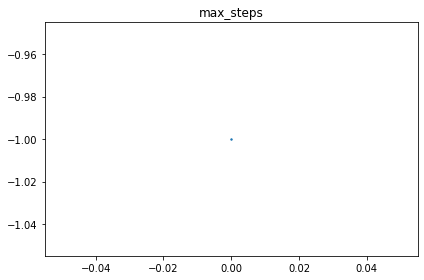

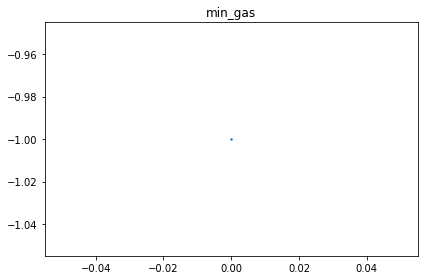

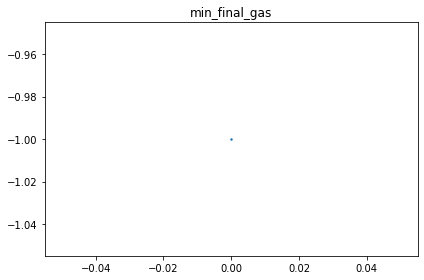

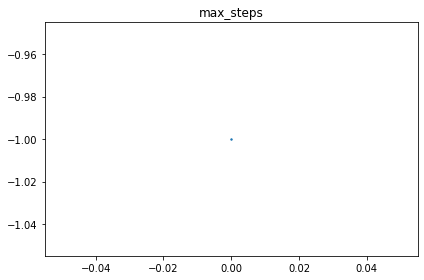

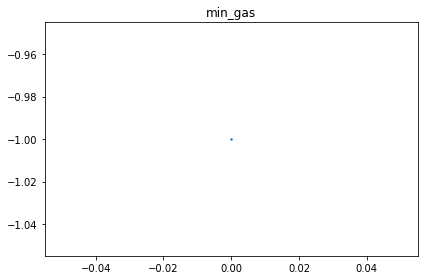

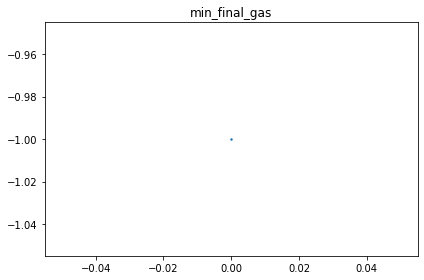

In [139]:
lables = ["max_steps", "min_gas", "min_final_gas"]
for i in range(6):
    plt.scatter(range(len(time_results)), [r[i] for r in time_results], s = 2)
    plt.title(lables[i%3])
    plt.show()

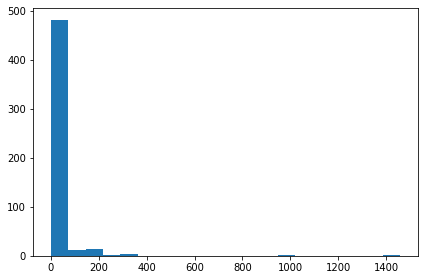

1457


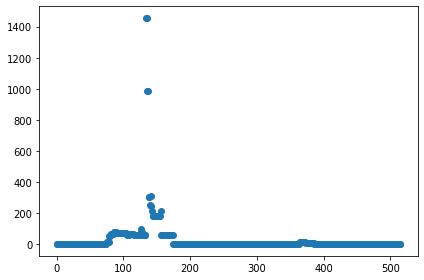

379


In [123]:
plt.hist(loops, 20)
plt.show()
print(max(loops))
plt.scatter(range(len(loops)), loops)
plt.show()
print(len([l for l in loops if l <= 6]))

# Analysis big data set

In [166]:
running_log = log[300:400]
#g, edge_mapping = transition_system(running_log, 3, sequence)
g =  build_dfg(running_log, 3)
draw_dfg(g, "graph.ps")

extend_graph_with_actors(g,actors)
edge_cost = compute_edge_cost(g, running_log)
g = annotate_graph(g, edge_cost)

g_outgoing = color_graph(g)
g_outgoing = nx.relabel_nodes(g_outgoing, naming)
draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

True
plotted graph.ps
Edge cost was computed


In [164]:
print(len(list(nx.simple_cycles(g))))

132


In [ ]:
g_unroll = unroll(g, "start", ["finPos", "finNeg"], 1)
A = to_agraph(g_unroll)
A.layout('dot')
if SAVE_ELEMENTS:
    A.draw('unrolled.ps')

-3936737091066850.0


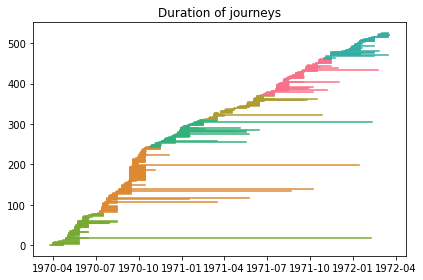

In [274]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

n_clusters = 6
r_state = 2359

X = [float(s.timestamp()) for s in start_times]
X = np.array(X).reshape(-1,1)
model = BayesianGaussianMixture(n_components=n_cluster, random_state=r_state, max_iter = 1000000).fit(X)

model = KMeans(n_clusters=n_clusters, random_state=r_state).fit(X)
print(model.score(X))

sorted_times = sorted(times.items(), key=lambda item: item[1])
count = 0
for t in sorted_times:
    cluster = model.predict([[t[1][0].timestamp()]])[0]
    plt.plot([t[1][0],t[1][1]], [count, count], c= sns.color_palette("husl", 10)[cluster])
    count += 1
plt.title("Duration of journeys")
plt.show()

In [270]:
clustered_logs = []
predictions = model.predict(X)
for c in range(n_clusters):
    clustered_logs.append([log[i] for i in range(len(log)) if predictions[i] == c])
print(len(clustered_logs))

1


In [271]:
for i in range(len(clustered_logs)):
    l = clustered_logs[i]
    print("log", i)
    print("has length", len(l))
    print("ratio", len([t for t in l if "finPos" in t])/len(l))
    print("total cancellations", len([t for t in l if "finNeg" in t]))

log 0
has length 526
ratio 0.7129277566539924
total cancellations 151


In [273]:
#g, edge_mapping = transition_system(running_log, 3, sequence)
for i in range(len(clustered_logs)):
    l = clustered_logs[i]
    edge_threshold = 3

    g =  build_dfg(l, edge_threshold)
    #g, edge_mapping = transition_system(l, 3, ms)
    loop_number = len(list(nx.simple_cycles(g)))
    #while(loop_number>10):
    #    edge_threshold += 1
    #    g =  build_dfg(l, edge_threshold)
    #    loop_number = len(list(nx.simple_cycles(g)))
    print("edge_threshold", edge_threshold, "with", loop_number, "loops")
    extend_graph_with_actors(g,actors)
    edge_cost = compute_edge_cost(g, l)
    g = annotate_graph(g, edge_cost)

    draw_dfg(g, "./clusters/graph"+str(i)+".ps")
    
    g_outgoing = color_graph(g)
    g_outgoing = nx.relabel_nodes(g_outgoing, naming)
    draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

edge_threshold 3 with 6418 loops
Edge cost was computed
plotted ./clusters/graph0.ps
